## For reading the .dcm files


### Robust DICOM File Reader

In [1]:
import pydicom
import numpy as np
import cv2

def read_dicom_file(path):
    try:
        ds = pydicom.dcmread(path)

        # Extract pixel data
        img = ds.pixel_array.astype(np.float32)

        # Apply rescale slope/intercept if available
        slope = float(ds.get("RescaleSlope", 1))
        intercept = float(ds.get("RescaleIntercept", 0))
        img = img * slope + intercept

        # Normalize image to 0–255
        img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        return img_normalized, ds, "✅ DICOM read and processed"

    except Exception as e:
        return None, None, f"❌ Failed to read DICOM: {e}"


### Metadata Extraction (Standard + Important Private Tags)

### For selective tags

In [2]:
def extract_dicom_metadata(ds):
    metadata = {
        "Patient Name": str(ds.get("PatientName", "N/A")),
        "Patient ID": ds.get("PatientID", "N/A"),
        "Modality": ds.get("Modality", "N/A"),
        "Manufacturer": ds.get("Manufacturer", "N/A"),
        "Photometric Interpretation": ds.get("PhotometricInterpretation", "N/A"),
        "Rows": ds.get("Rows", "N/A"),
        "Columns": ds.get("Columns", "N/A"),
        "Pixel Spacing": ds.get("PixelSpacing", "N/A"),
        "Bits Stored": ds.get("BitsStored", "N/A"),
        "Tooth Region": (
            ds[0x0008, 0x2228][0].get("CodeMeaning", "N/A")
            if (0x0008, 0x2228) in ds else "N/A"
        ),
        "Sharpness (if present)": ds.get((0x0009, 0x11B2), "N/A"),
    }
    return metadata


### For all the Tags

In [3]:
def extract_all_dicom_tags(ds):
    all_tags = {}

    for elem in ds.iterall():
        tag = f"{elem.tag} ({elem.keyword})"
        if elem.VR == "SQ":  # Sequence
            try:
                all_tags[tag] = [dict(item) for item in elem.value]
            except Exception:
                all_tags[tag] = str(elem.value)
        else:
            all_tags[tag] = str(elem.value)

    return all_tags


### Visualize Raw DICOM Image

In [4]:
import matplotlib.pyplot as plt

def visualize_dicom_image(image, title="Raw DICOM Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


### Test

✅ DICOM read and processed


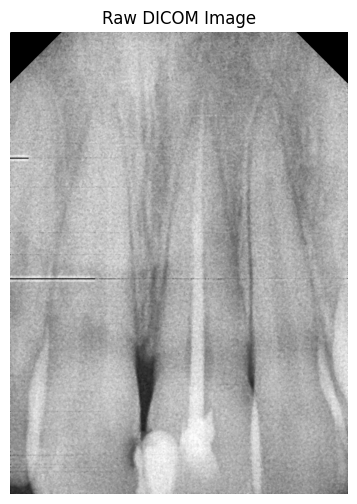


📝 DICOM Metadata:
(0008,0020) (StudyDate): 20250218
(0008,0021) (SeriesDate): 20250218
(0008,0030) (StudyTime): 193621
(0008,0031) (SeriesTime): 193621
(0008,0060) (Modality): IO
(0008,0070) (Manufacturer): EWOOSOFT
(0010,0010) (PatientName):  naglaxmi
(0010,0020) (PatientID): 20250209_111652
(0010,0030) (PatientBirthDate): 20250101
(0010,0040) (PatientSex): W
(0010,1010) (PatientAge): 0
(0018,1020) (SoftwareVersions): 3.1.5.1
(0018,5101) (ViewPosition): AP
(0020,0013) (InstanceNumber): 1
(0028,0002) (SamplesPerPixel): 1
(0028,0004) (PhotometricInterpretation): MONOCHROME2
(0028,0006) (PlanarConfiguration): 0
(0028,0010) (Rows): 1095
(0028,0011) (Columns): 800
(0028,0030) (PixelSpacing): [0.0296, 0.0296]
(0028,0100) (BitsAllocated): 8
(0028,0101) (BitsStored): 8
(0028,0102) (HighBit): 7
(0028,0103) (PixelRepresentation): 0
(0028,1050) (WindowCenter): 127
(0028,1051) (WindowWidth): 255
(0028,1052) (RescaleIntercept): 0
(0028,1053) (RescaleSlope): 1
(0028,1054) (RescaleType): US
(7FE0,0

In [5]:
file_path = "Images_Data_science_intern/IS20250218_193621_8940_10081171.dcm"

# Step 1: Read image + metadata
img, ds, status = read_dicom_file(file_path)
print(status)

# Step 2: Show the image
if img is not None:
    visualize_dicom_image(img)
else:
    print("Image display skipped due to load failure.")

# Step 3: Extract and print metadata
if ds is not None:
    #meta = extract_dicom_metadata(ds) - for selectice meta data
    meta = extract_all_dicom_tags(ds) # for all the meta data
    print("\n📝 DICOM Metadata:")
    for k, v in meta.items():
        print(f"{k}: {v}")


### Meta data summary to save in .csv

In [6]:
import os
import pandas as pd

def extract_metadata_batch(folder):
    records = []

    for file in os.listdir(folder):
        if file.lower().endswith((".dcm", ".rvg")):
            filepath = os.path.join(folder, file)
            try:
                ds = pydicom.dcmread(filepath)
                metadata = extract_dicom_metadata(ds)
                metadata["filename"] = file
                records.append(metadata)
                print(f"✅ Processed: {file}")
            except Exception as e:
                print(f"❌ Failed: {file} — {e}")

    # Save to CSV
    df = pd.DataFrame(records)
    df.to_csv("dicom_metadata_summary.csv", index=False)
    print("\n📁 Metadata log saved to dicom_metadata_summary.csv")


In [7]:
# folder_path="C:\Users\Admin\OneDrive\Desktop\vscode\DObbe AI data science intern\Images_Data_science_intern"
# extract_metadata_batch(folder_path)

# Replace this path with your actual folder
dicom_folder_path = "Images_Data_science_intern"

# Call the batch extraction function
extract_metadata_batch(dicom_folder_path)


✅ Processed: IS20250115_171841_9465_61003253.dcm
✅ Processed: IS20250115_190348_9148_86297118.dcm
✅ Processed: IS20250115_191316_7227_10120577.dcm
✅ Processed: IS20250116_180218_7445_56958340.dcm
✅ Processed: IS20250218_193552_3393_78829426.dcm
✅ Processed: IS20250218_193621_8940_10081171.dcm
✅ Processed: IS20250221_192657_5718_56712676.dcm
✅ Processed: R10.rvg
✅ Processed: R4.rvg
✅ Processed: R5.rvg
✅ Processed: R6.rvg
✅ Processed: R7.rvg
✅ Processed: R9.rvg

📁 Metadata log saved to dicom_metadata_summary.csv


## Step 1 - DICOM File handling complete

# Step 2 - Initial Image Analysis & Characterization:


 Brightness

In [8]:
# Mean pixel intensity
def compute_brightness(image):
    return np.mean(image)

# histogram
def plot_histogram(image, title="Pixel Intensity Histogram"):
    plt.figure()
    plt.hist(image.ravel(), bins=256, range=[0, 256])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()


 Contrast

In [9]:
#Standard Deviation - spread
def compute_contrast_std(image):
    return np.std(image)
#Michelson Contrast - for regions
def compute_michelson_contrast(image):
    I_max, I_min = np.max(image), np.min(image)
    return (I_max - I_min) / (I_max + I_min + 1e-5)
# RMS Contrast
def compute_rms_contrast(image):
    mean_intensity = np.mean(image)
    return np.sqrt(np.mean((image - mean_intensity) ** 2))


 Sharpness

In [10]:
#Laplacian Variance (high = sharp)
def compute_laplacian_sharpness(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()
#Tenengrad (Sobel gradients)
def compute_tenengrad_sharpness(image):
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    grad_magnitude = np.sqrt(gx**2 + gy**2)
    return np.mean(grad_magnitude)


 Noise

In [11]:
def estimate_noise_std(image, block_size=32):
    h, w = image.shape
    noise_vals = []

    for y in range(0, h - block_size, block_size):
        for x in range(0, w - block_size, block_size):
            block = image[y:y+block_size, x:x+block_size]
            if cv2.Laplacian(block, cv2.CV_64F).var() < 5:  # flat region
                noise_vals.append(np.std(block))

    return np.mean(noise_vals) if noise_vals else 0


Visulaise the data

In [12]:
def analyze_image_quality_batch(folder):
    records = []

    for file in os.listdir(folder):
        if file.lower().endswith((".dcm", ".rvg")):
            path = os.path.join(folder, file)
            img, ds, status = read_dicom_file(path)
            if img is not None:
                metrics = {
                    "filename": file,
                    "brightness": compute_brightness(img),
                    "contrast_std": compute_contrast_std(img),
                    "michelson_contrast": compute_michelson_contrast(img),
                    "rms_contrast": compute_rms_contrast(img),
                    "sharpness_laplacian": compute_laplacian_sharpness(img),
                    "sharpness_tenengrad": compute_tenengrad_sharpness(img),
                    "noise_estimate": estimate_noise_std(img)
                }
                records.append(metrics)
            else:
                print(f"❌ Image skipped: {file}")

    df = pd.DataFrame(records)
    df.to_csv("image_quality_metrics.csv", index=False)
    print("📈 Image quality metrics saved to image_quality_metrics.csv")


test the metrics code

In [13]:
analyze_image_quality_batch(dicom_folder_path)

📈 Image quality metrics saved to image_quality_metrics.csv


### test for logging function - works well for single images and there comparison

In [14]:
import pandas as pd
import os

def compute_image_metrics(image, filename, operation):
    metrics = {
        "filename": filename,
        "preprocessing_operation": operation,
        "brightness": compute_brightness(image),
        "contrast_std": compute_contrast_std(image),
        "michelson_contrast": compute_michelson_contrast(image),
        "rms_contrast": compute_rms_contrast(image),
        "sharpness_laplacian": compute_laplacian_sharpness(image),
        "sharpness_tenengrad": compute_tenengrad_sharpness(image),
        "noise_estimate": estimate_noise_std(image)
    }

    # Append to CSV
    csv_path = "test_image_quality_metrics.csv"
    # Load existing file if it exists
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)

        # Check if entry already exists
        is_duplicate = ((df["filename"] == filename) & 
                        (df["preprocessing_operation"] == operation)).any()

        if is_duplicate:
            print(f"⚠️ Skipped duplicate entry for {filename} ({operation})")
            return metrics  # Still return metrics but don’t write to file

        # Append new entry
        df = pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)
    else:
        df = pd.DataFrame([metrics])
    
    
    # if os.path.exists(csv_path):
    #     df = pd.read_csv(csv_path)
    #     df = pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)
    # else:
    #     df = pd.DataFrame([metrics])

    df.to_csv(csv_path, index=False)
    print(f"📊 Logged metrics for {filename} ({operation})")
    
    return metrics

In [15]:
file_path_test="Images_Data_science_intern\IS20250115_171841_9465_61003253.dcm"
# For original image
img, ds, status = read_dicom_file(file_path_test)
if img is not None:
    compute_image_metrics(img, filename=os.path.basename(file_path), operation="original")


⚠️ Skipped duplicate entry for IS20250218_193621_8940_10081171.dcm (original)


test code - don't run again

In [16]:
# equalized_img = cv2.equalizeHist(img)
# compute_image_metrics(equalized_img, filename=os.path.basename(file_path), operation="static_equalization")


## To visualize the iamge metrics

histograms - freq distrution

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histograms(df, columns):
    for col in columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()


box plots - spotting outliers and comparing metrics ranges

In [18]:
def plot_boxplots(df, columns):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[columns])
    plt.title("Boxplot of Image Quality Metrics")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


pair plot - realation betwenn metrics

In [19]:
def plot_pairwise_relationships(df, columns):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.pairplot(df[columns])
    plt.suptitle("Pairwise Relationships Between Image Quality Metrics", y=1.02)
    plt.show()


violin plot - to see the metrics distrubution

In [20]:
def plot_violin_by_operation(df, metric):
    plt.figure(figsize=(8, 5))
    sns.violinplot(x="preprocessing_operation", y=metric, data=df)
    plt.title(f"{metric} Distribution by Preprocessing Type")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


Correlation heatmaps - sttrenght of realtions

In [21]:
def plot_correlation_heatmap(df, columns):
    corr = df[columns].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Between Image Quality Metrics")
    plt.show()


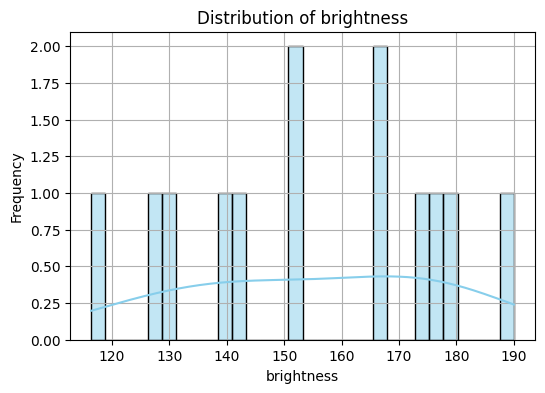

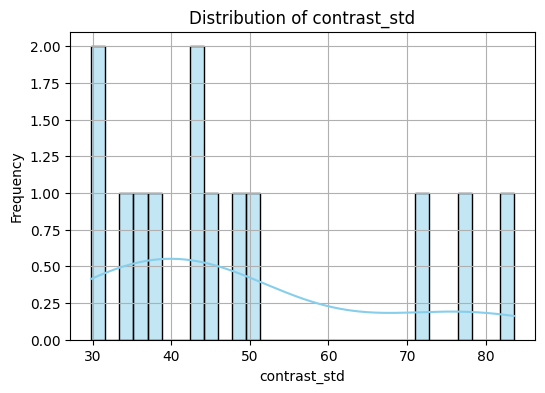

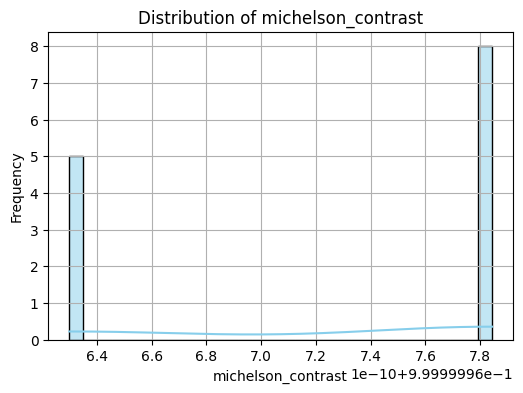

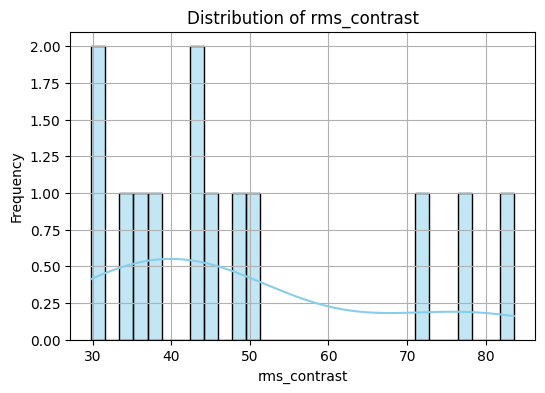

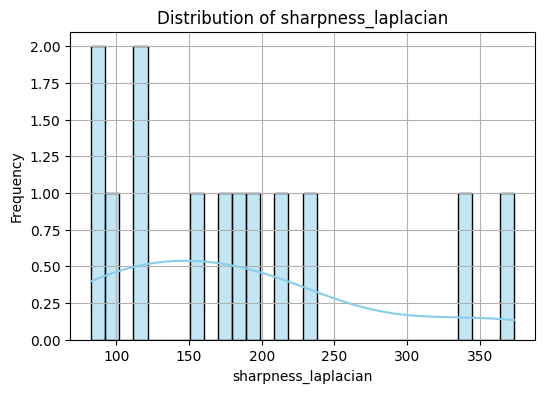

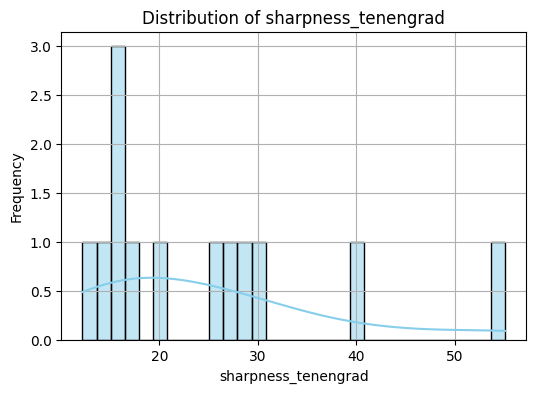

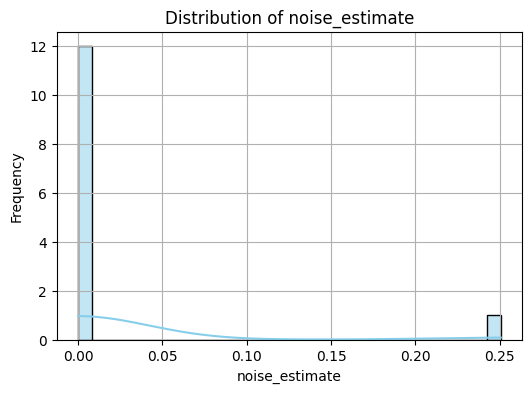

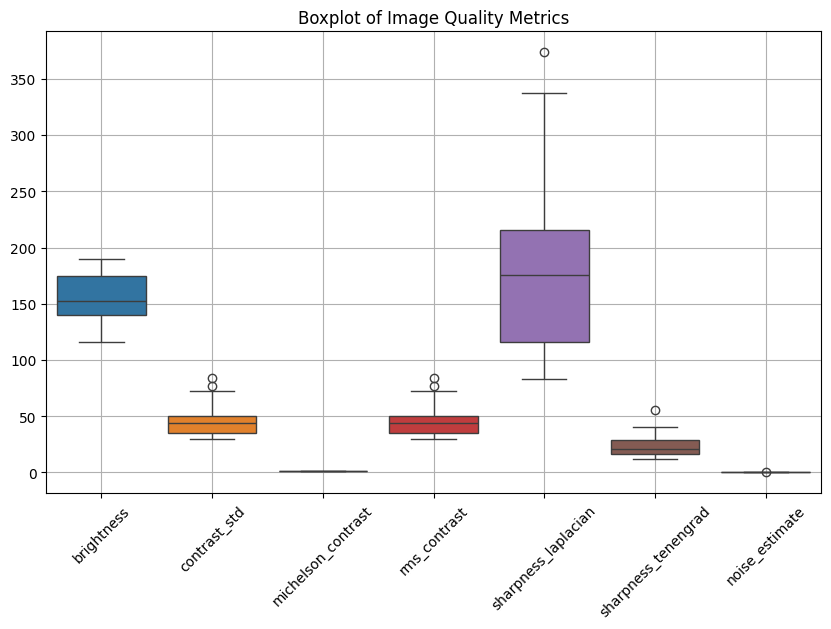

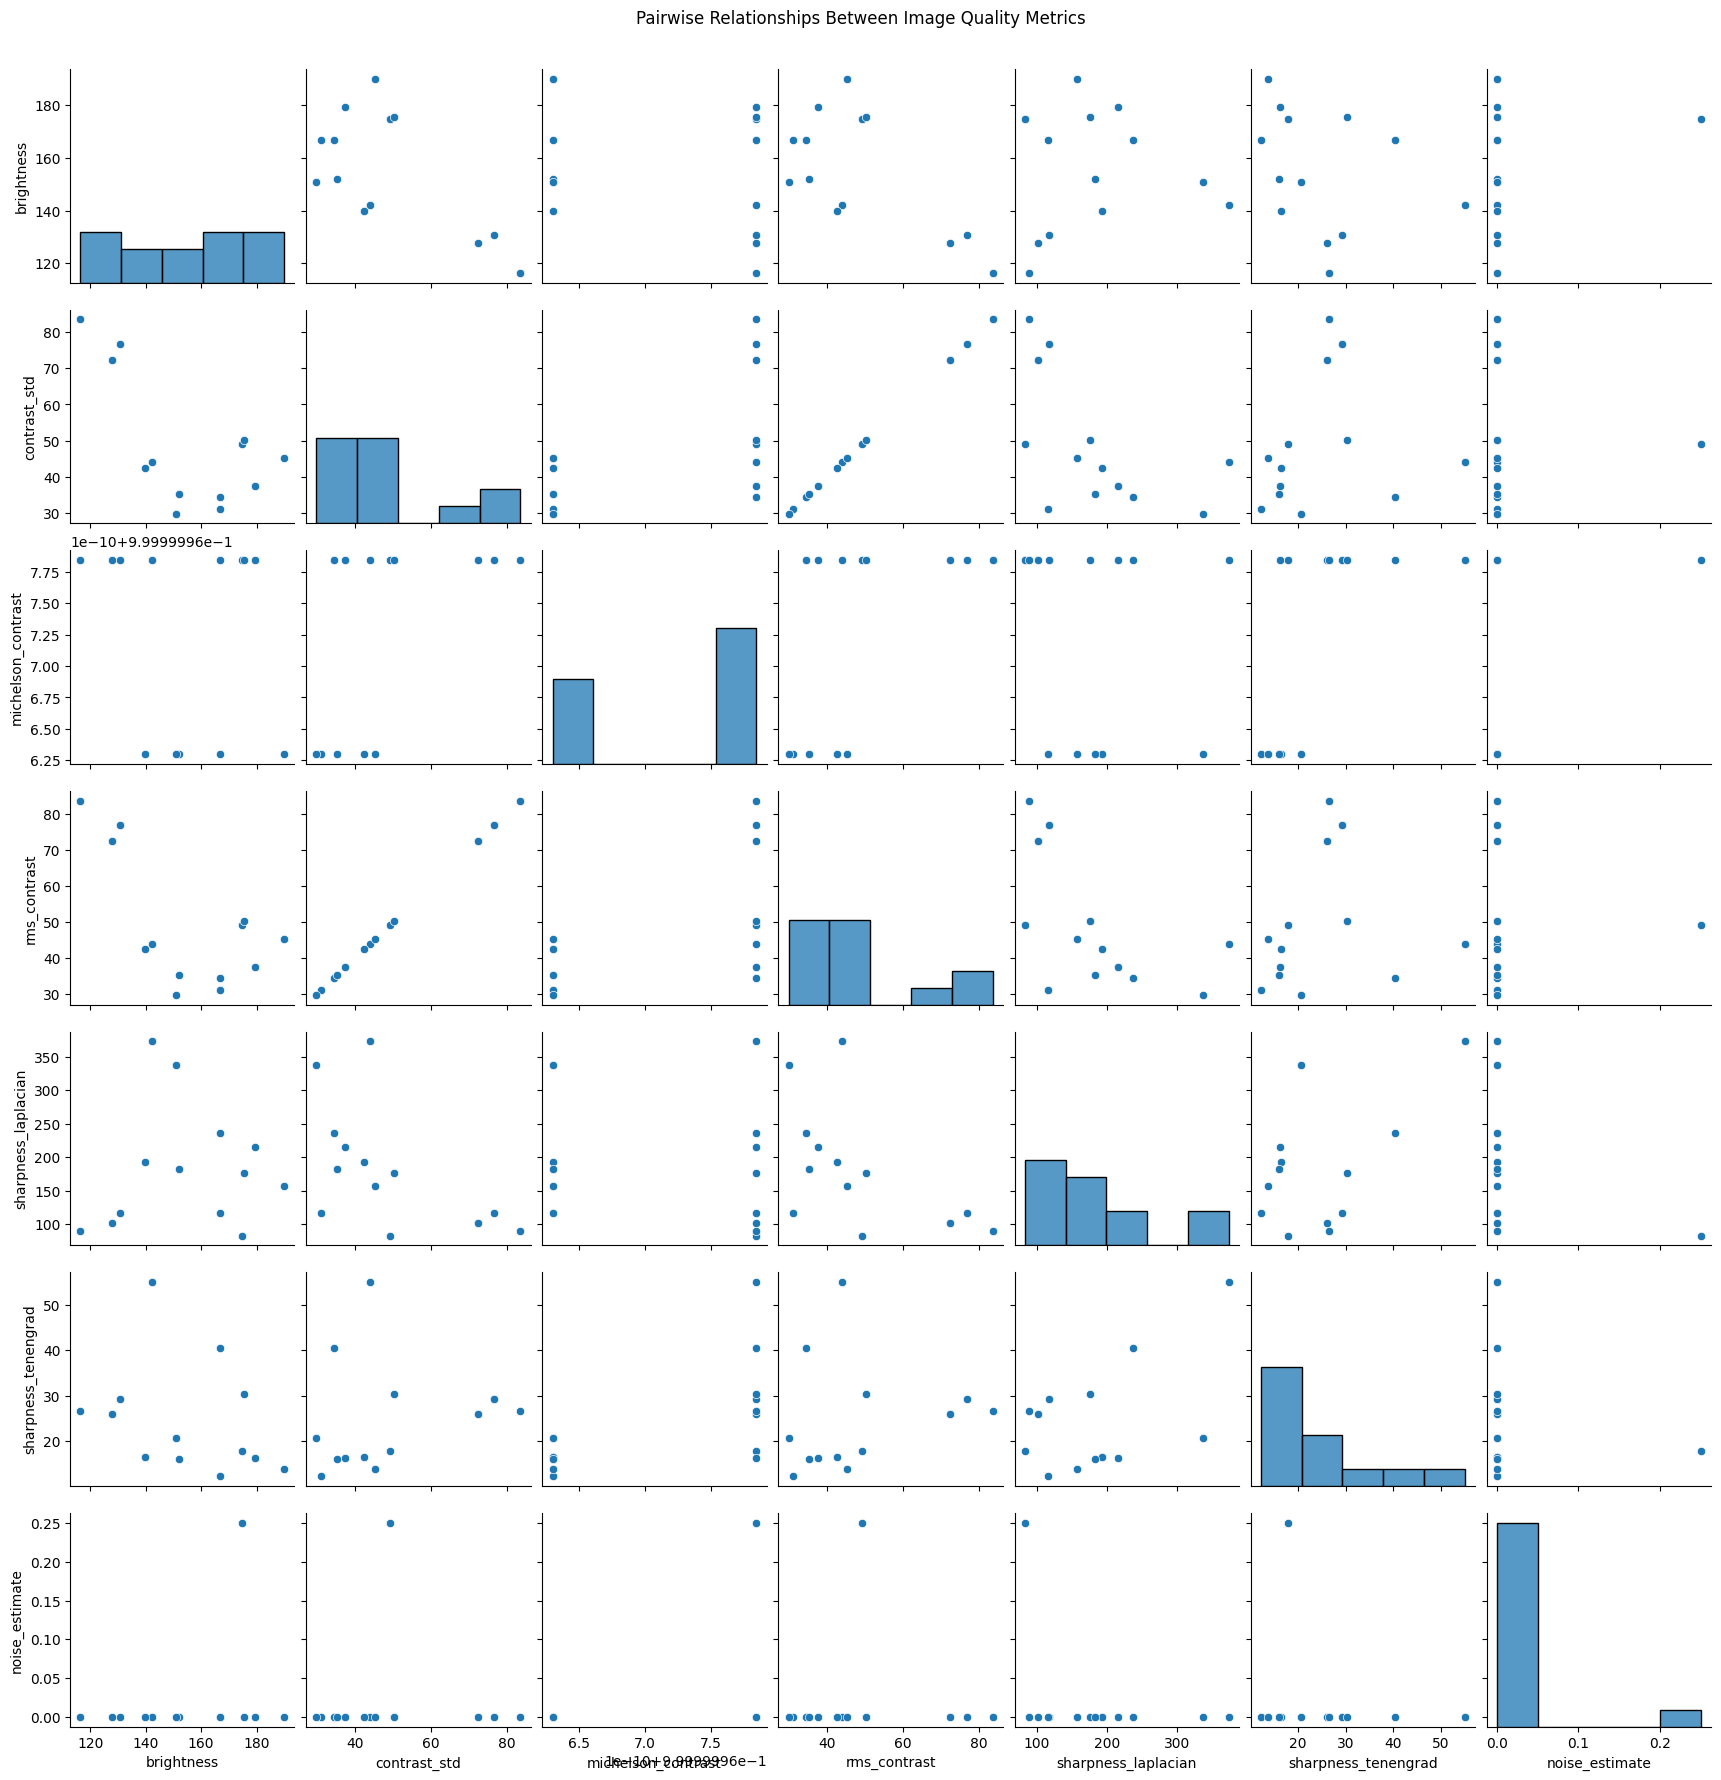

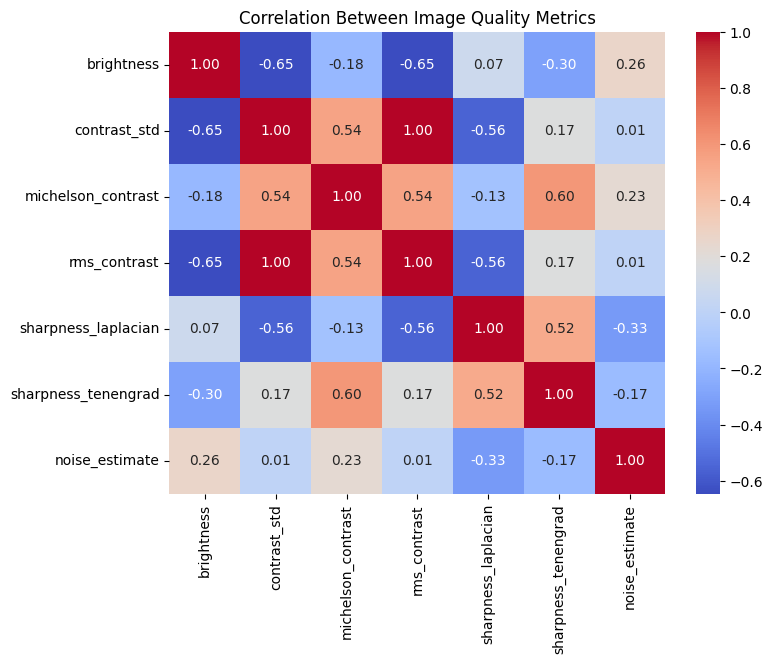

In [22]:
quality_columns = [
    "brightness",
    "contrast_std",
    "michelson_contrast",
    "rms_contrast",
    "sharpness_laplacian",
    "sharpness_tenengrad",
    "noise_estimate"
]

# Example calls
df = pd.read_csv("image_quality_metrics.csv")
plot_histograms(df, quality_columns)
plot_boxplots(df, quality_columns)
plot_pairwise_relationships(df, quality_columns)
plot_correlation_heatmap(df, quality_columns)


### Advanced - optional - PCA + Clusterig + 3D plots

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [24]:
df = pd.read_csv("image_quality_metrics.csv")

# Select only the metric columns
features = [
    "brightness", "contrast_std", "michelson_contrast", "rms_contrast",
    "sharpness_laplacian", "sharpness_tenengrad", "noise_estimate"
]

X = df[features].dropna()

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


PCA

In [25]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratios: {pca.explained_variance_ratio_}")


Explained variance ratios: [0.45315496 0.26217125 0.18005006]


In [26]:
# pca.components_ shape: (n_components, n_features)
loadings = pca.components_

# Create a DataFrame for easier interpretation
import pandas as pd

feature_names = ["brightness", "contrast_std", "michelson_contrast", "rms_contrast",
                 "sharpness_laplacian", "sharpness_tenengrad", "noise_estimate"]

loadings_df = pd.DataFrame(loadings.T, index=feature_names, columns=["PC1", "PC2", "PC3"])

print(loadings_df)


                          PC1       PC2       PC3
brightness          -0.388280 -0.211853  0.410697
contrast_std         0.547225 -0.081945 -0.097070
michelson_contrast   0.375322  0.194035  0.547823
rms_contrast         0.547225 -0.081945 -0.097070
sharpness_laplacian -0.278237  0.601197  0.035997
sharpness_tenengrad  0.177154  0.630449  0.301531
noise_estimate       0.025752 -0.380965  0.648194


In [ ]:
# Sort features by absolute contribution to PC1
print("PC1")
print(loadings_df["PC1"].abs().sort_values(ascending=False))
# Sort features by absolute contribution to PC2
print("PC2")
print(loadings_df["PC2"].abs().sort_values(ascending=False))
# Sort features by absolute contribution to PC3
print("PC3")
print(loadings_df["PC3"].abs().sort_values(ascending=False))


PC1
rms_contrast           0.547225
contrast_std           0.547225
brightness             0.388280
michelson_contrast     0.375322
sharpness_laplacian    0.278237
sharpness_tenengrad    0.177154
noise_estimate         0.025752
Name: PC1, dtype: float64
PC2
sharpness_tenengrad    0.630449
sharpness_laplacian    0.601197
noise_estimate         0.380965
brightness             0.211853
michelson_contrast     0.194035
contrast_std           0.081945
rms_contrast           0.081945
Name: PC2, dtype: float64
PC3
noise_estimate         0.648194
michelson_contrast     0.547823
brightness             0.410697
sharpness_tenengrad    0.301531
rms_contrast           0.097070
contrast_std           0.097070
sharpness_laplacian    0.035997
Name: PC3, dtype: float64


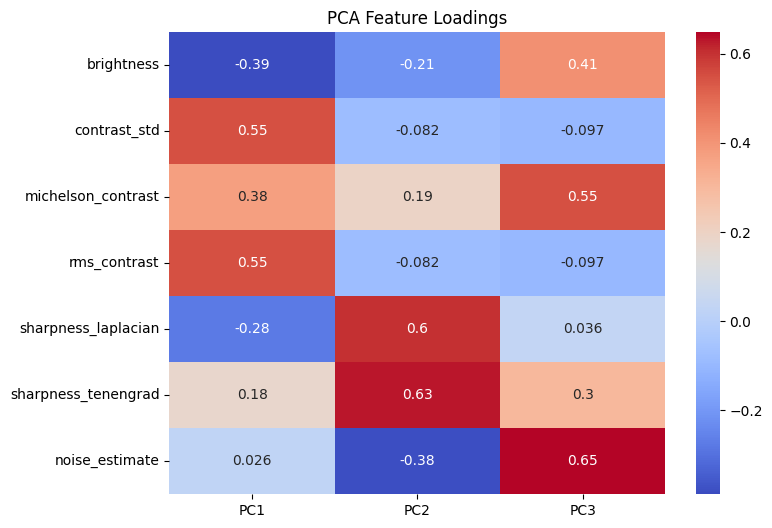

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm")
plt.title("PCA Feature Loadings")
plt.show()


### PC1(45%) - 	rms_contrast, contrast_std, brightness 
### PC2(26%) -  sharpness_tenengrad, sharpness_laplacian,noise_estimate
### PC3(18%) - noise_estimate, michelson_contrast, brightness

## Step 2 - Complete 

# Step 3 - Static Preprocessing (Baseline):



fixed steps on every image, without adapting to image quality

Denoising - to clean images without losing important points
    dental/xray spefic  - bilateral filter or wvelet based denoising

Contrast Enhancement - improves visibility in low-contrast images
    Histogram equalization to #enhance contrast# (fixed). - radiography - CLAHE

sharpening - enhance edges and fine structures
    Unsharp Masking

Normalisation



### i will apply some simple and basic preprocessing steps



Histogram for equalisation 

shapness - Sharpeing filter 

Gaussian blur - basic denoising
 

In [29]:
import cv2
import numpy as np

def static_preprocessing(image):
    # 1. Histogram Equalization (for contrast enhancement)
    hist_eq = cv2.equalizeHist(image)
    
    # 2. Sharpening with unsharp masking
    gaussian = cv2.GaussianBlur(hist_eq, (5,5), 1.0)
    sharpened = cv2.addWeighted(hist_eq, 1.5, gaussian, -0.5, 0)
    
    # 3. Basic denoising using Gaussian Blur
    denoised = cv2.GaussianBlur(sharpened, (3,3), 0)
    
    return denoised


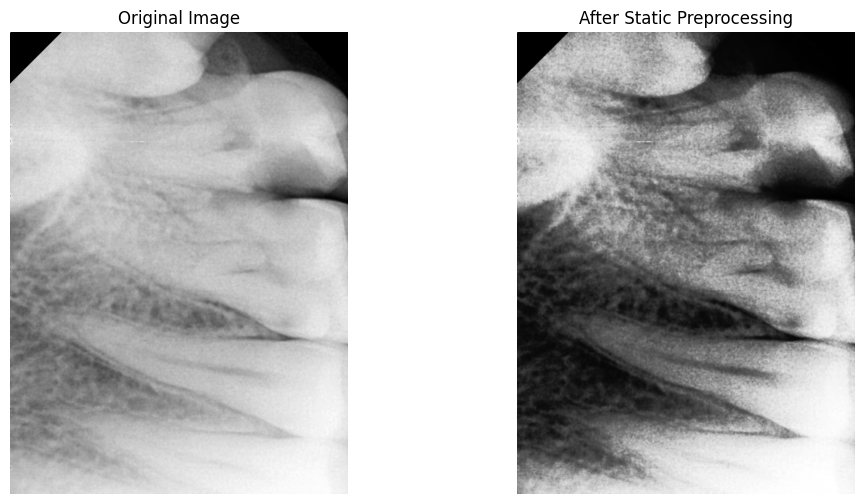

In [30]:
# Assume 'img' is your raw DICOM image loaded earlier

static_img = static_preprocessing(img)

# Visualize side-by-side comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("After Static Preprocessing")
plt.imshow(static_img, cmap='gray')
plt.axis('off')

plt.show()


In [31]:
# equalized_img = cv2.equalizeHist(img)
compute_image_metrics(static_img, filename=os.path.basename(file_path), operation="static_preprocessing")


⚠️ Skipped duplicate entry for IS20250218_193621_8940_10081171.dcm (static_preprocessing)


{'filename': 'IS20250218_193621_8940_10081171.dcm',
 'preprocessing_operation': 'static_preprocessing',
 'brightness': 126.39076369863014,
 'contrast_std': 74.99202708815912,
 'michelson_contrast': 0.9999999607843153,
 'rms_contrast': 74.99202708815912,
 'sharpness_laplacian': 35.76438297215968,
 'sharpness_tenengrad': 32.394453066174584,
 'noise_estimate': 2.0936089706692287}

saving the preprocessed image

In [32]:
# Save the preprocessed image
output_dir = "preprocessed_images"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(file_path))[0]}_static.png")
cv2.imwrite(output_path, static_img)
print(f"🖼️ Saved preprocessed image to {output_path}")


🖼️ Saved preprocessed image to preprocessed_images\IS20250218_193621_8940_10081171_static.png


### Function for saving the images

In [33]:
def save_preprocessed_image(image, file_path, suffix, folder="preprocessed_images"):
    os.makedirs(folder, exist_ok=True)
    filename = f"{os.path.splitext(os.path.basename(file_path))[0]}_{suffix}.png"
    output_path = os.path.join(folder, filename)
    cv2.imwrite(output_path, image)
    print(f"🖼️ Saved preprocessed image to {output_path}")
    return output_path


### Check test_image_quality_metrics.csv for the compete metrics


## Limitations



Noise Amplification - Global operations can enhance noise, especially in flat regions or low-signal areas. This is a critical failure point in medical imaging.

Brightness Shift - static filters (histogram equlisation) : can unintentionally darken or brighten an image without considering its original lighting context.

Excessive Contrast Boost - Too much contrast enhancement can saturate highlights and shadows — washing out diagnostic subtleties

Sharpness Inconsistencies - Different sharpness metrics tell a mixed story, showing why adaptive control is needed — not one-size-fits-all filters.

### Metrics shift

noise :- 0.2 -> 2.5

brightness :- 174 -> 126

Contrast :- 49 -> 74

Sharpeness :- irregular change in shapness (increase and decrease)




The static pipeline treats all images the same, ignoring their unique quality attributes.

This leads to suboptimal or even harmful results on images that don't fit the “average” profile.

Adaptive methods are needed to customize parameters to each image’s initial quality.



## Step 3 - Complete

## Gathering info abou the data

In [34]:
import pandas as pd

# Load the CSV
df = pd.read_csv('image_quality_metrics.csv')

# Print all column names
print("Column names:", df.columns.tolist())

# Extract each column and store separately
for column in df.columns:
    # Store each column as a separate variable in a dictionary
    globals()[column] = df[column]
    print(f"\nColumn: {column}")
    print(df[column].head())  # Show first 5 values


Column names: ['filename', 'brightness', 'contrast_std', 'michelson_contrast', 'rms_contrast', 'sharpness_laplacian', 'sharpness_tenengrad', 'noise_estimate']

Column: filename
0    IS20250115_171841_9465_61003253.dcm
1    IS20250115_190348_9148_86297118.dcm
2    IS20250115_191316_7227_10120577.dcm
3    IS20250116_180218_7445_56958340.dcm
4    IS20250218_193552_3393_78829426.dcm
Name: filename, dtype: object

Column: brightness
0    174.680312
1    130.841968
2    127.776491
3    116.353666
4    175.434204
Name: brightness, dtype: float64

Column: contrast_std
0    49.159848
1    76.732539
2    72.300866
3    83.571523
4    50.173657
Name: contrast_std, dtype: float64

Column: michelson_contrast
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: michelson_contrast, dtype: float64

Column: rms_contrast
0    49.159848
1    76.732539
2    72.300866
3    83.571523
4    50.173657
Name: rms_contrast, dtype: float64

Column: sharpness_laplacian
0     82.741920
1    116.697883
2    101.514380


In [35]:
import pandas as pd

# Load the CSV
df = pd.read_csv('image_quality_metrics.csv')

# Iterate through each column
for column in df.columns:
    print(f"\n--- Column: {column} ---")
    
    # Display type of data
    print("Data type:", df[column].dtype)
    
    # Basic stats for numeric columns
    if pd.api.types.is_numeric_dtype(df[column]):
        print("Mean:", df[column].mean())
        print("Median:", df[column].median())
        print("Std Dev:", df[column].std())
        print("Min:", df[column].min())
        print("Max:", df[column].max())
        
        # Example condition: values > mean
        high_values = df[df[column] > df[column].mean()]
        print(f"Values above mean (count={len(high_values)}):")
        print(high_values[[column]].head())

    # Operations for categorical or non-numeric columns
    else:
        print("Unique values:", df[column].unique())
        print("Value counts:")
        print(df[column].value_counts())



--- Column: filename ---
Data type: object
Unique values: ['IS20250115_171841_9465_61003253.dcm'
 'IS20250115_190348_9148_86297118.dcm'
 'IS20250115_191316_7227_10120577.dcm'
 'IS20250116_180218_7445_56958340.dcm'
 'IS20250218_193552_3393_78829426.dcm'
 'IS20250218_193621_8940_10081171.dcm'
 'IS20250221_192657_5718_56712676.dcm' 'R10.rvg' 'R4.rvg' 'R5.rvg'
 'R6.rvg' 'R7.rvg' 'R9.rvg']
Value counts:
filename
IS20250115_171841_9465_61003253.dcm    1
IS20250115_190348_9148_86297118.dcm    1
IS20250115_191316_7227_10120577.dcm    1
IS20250116_180218_7445_56958340.dcm    1
IS20250218_193552_3393_78829426.dcm    1
IS20250218_193621_8940_10081171.dcm    1
IS20250221_192657_5718_56712676.dcm    1
R10.rvg                                1
R4.rvg                                 1
R5.rvg                                 1
R6.rvg                                 1
R7.rvg                                 1
R9.rvg                                 1
Name: count, dtype: int64

--- Column: brightness ---
D

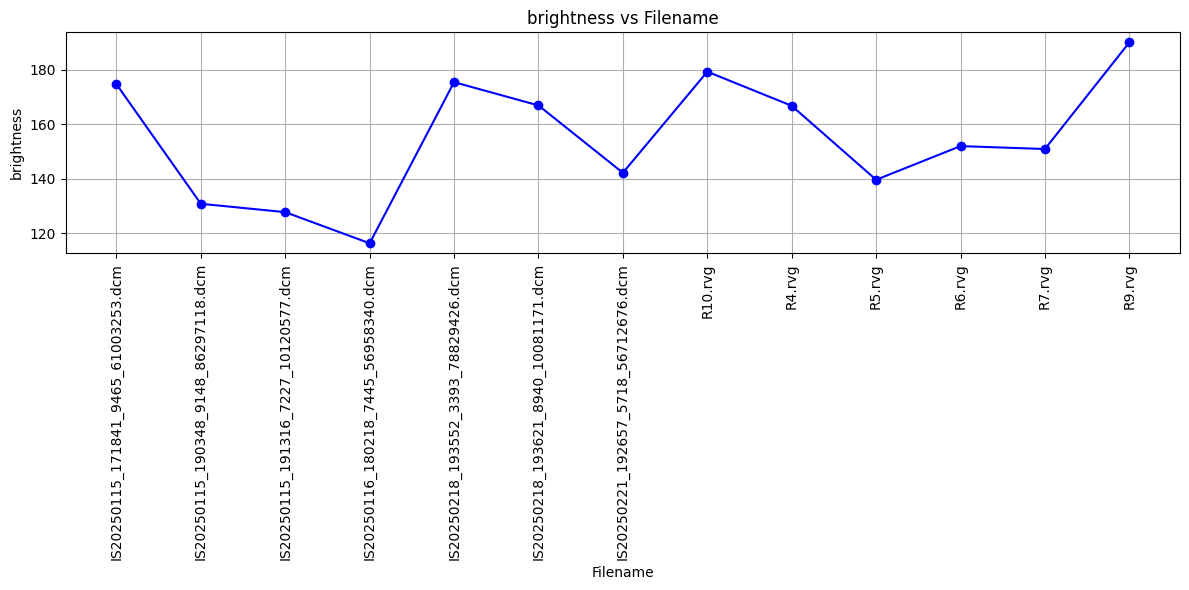

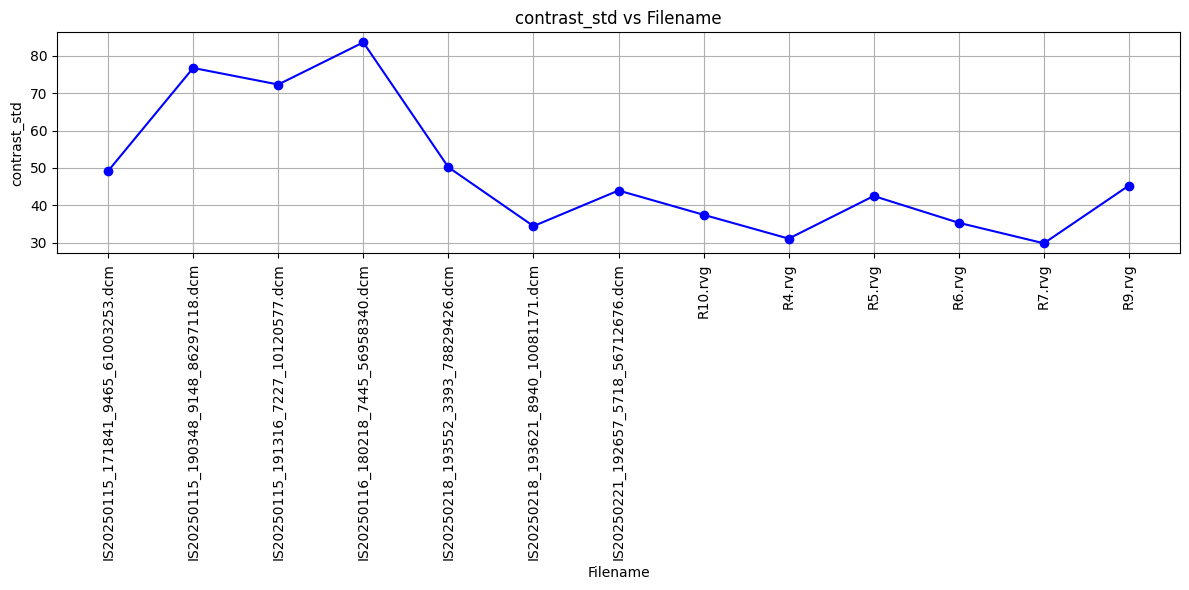

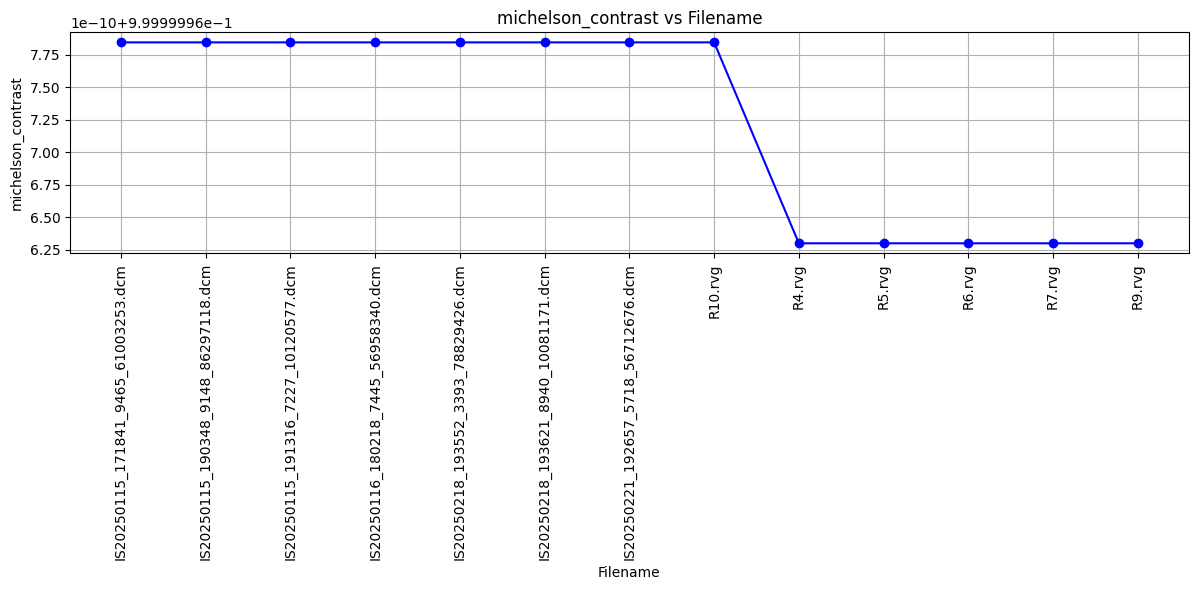

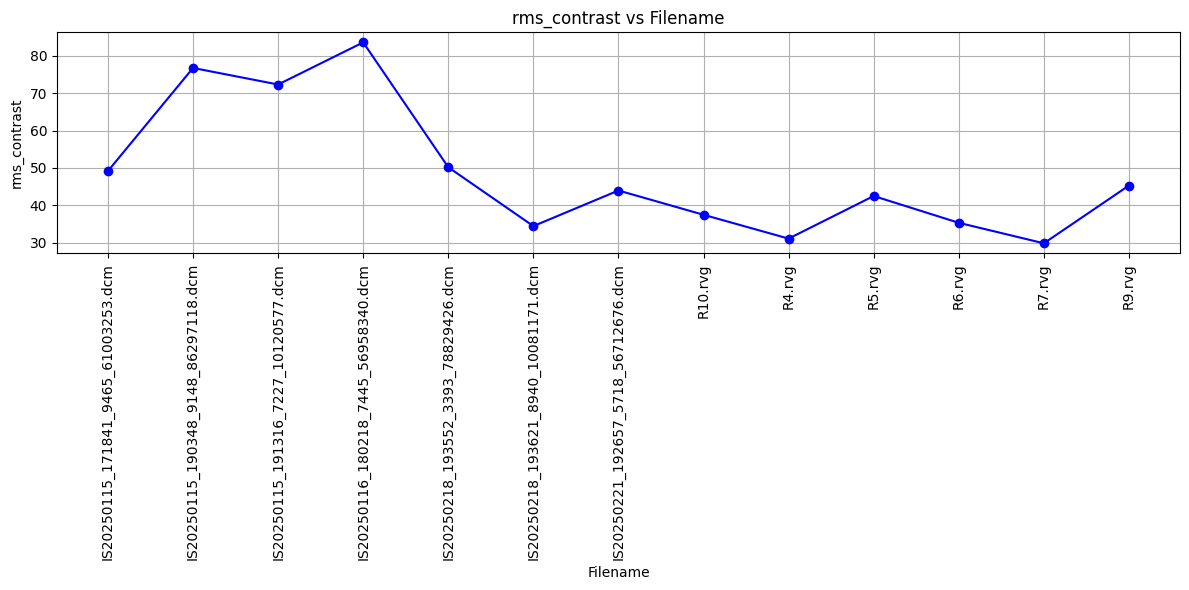

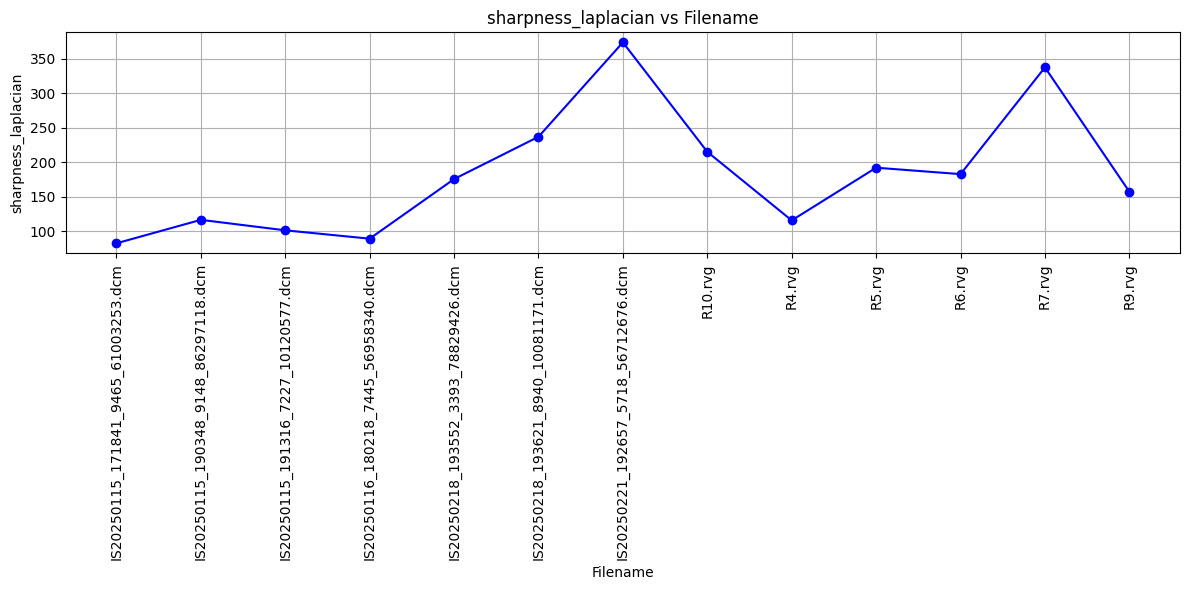

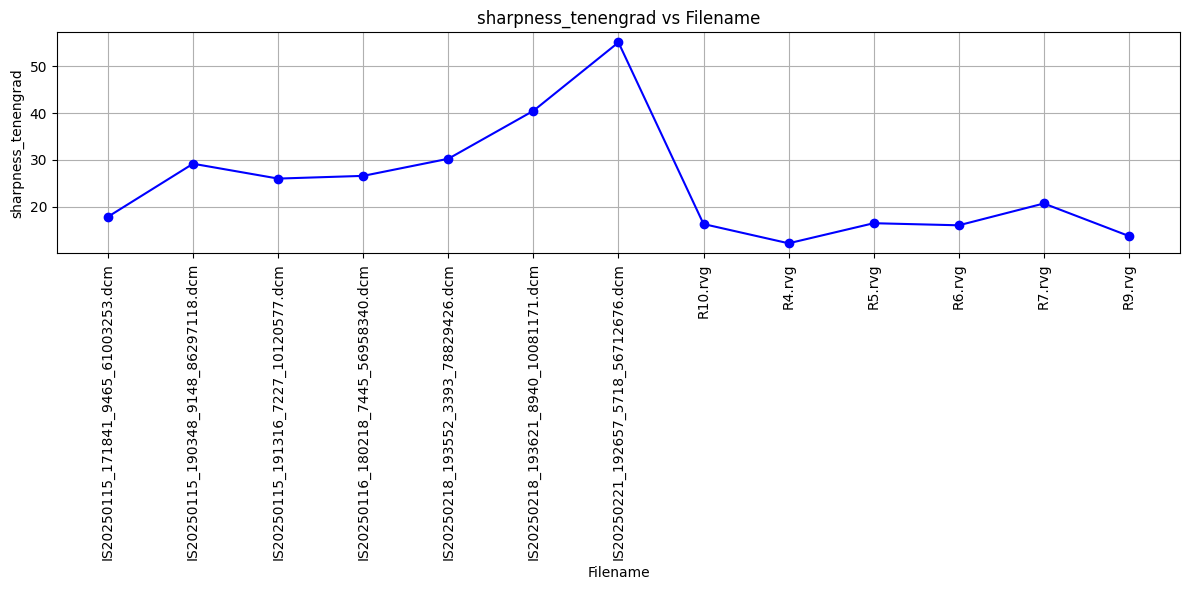

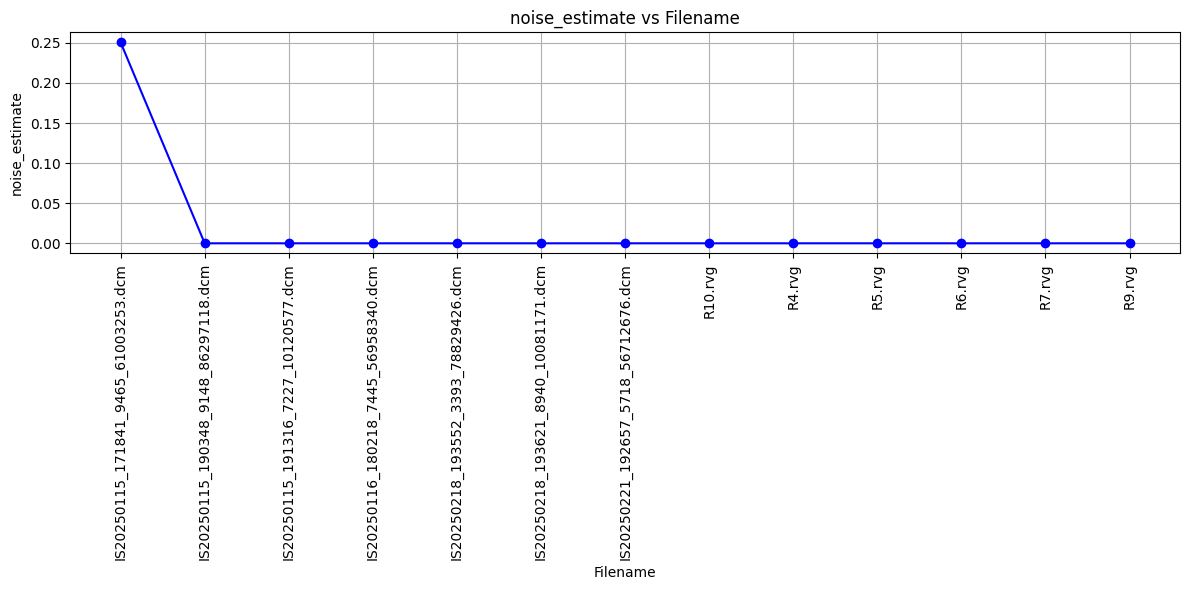

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv('image_quality_metrics.csv')

# Ensure 'filename' column is string type
df['filename'] = df['filename'].astype(str)

# Loop through each column except 'filename'
for column in df.columns:
    if column != 'filename':
        plt.figure(figsize=(12, 6))
        plt.plot(df['filename'], df[column], marker='o', linestyle='-', color='b')
        plt.title(f'{column} vs Filename')
        plt.xlabel('Filename')
        plt.ylabel(column)
        plt.xticks(rotation=90)  # Rotate filenames for readability
        plt.tight_layout()
        plt.grid(True)
        
        save_path = f'Plots/{column}.png'
        plt.savefig(save_path)
        
        plt.show()


# Step 4 - Adaptive Preprocessing Pipeline Development

## Algorithm-based Approach 


In [37]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, strength=1.0):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    mask = cv2.subtract(image, blurred)
    sharpened = cv2.addWeighted(image, 1.0, mask, strength, 0)
    return sharpened


In [38]:
# def adaptive_preprocessing(img, metrics):
#     processed = img.copy()

#     # Contrast adjustment
#     if metrics['contrast_std'] < 40:
#         clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
#         processed = clahe.apply(processed)
#     elif metrics['contrast_std'] < 60:
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#         processed = clahe.apply(processed)

#     # Sharpening
#     if metrics['sharpness_laplacian'] < 30:
#         processed = unsharp_mask(processed, strength=1.5)
#     elif metrics['sharpness_laplacian'] < 60:
#         processed = unsharp_mask(processed, strength=1.0)

#     # Denoising
#     if metrics['noise_estimate'] > 1.5:
#         processed = cv2.fastNlMeansDenoising(processed, None, h=10)
#     elif metrics['noise_estimate'] > 0.5:
#         processed = cv2.bilateralFilter(processed, d=9, sigmaColor=75, sigmaSpace=75)

#     return processed


import cv2
import numpy as np

def adaptive_preprocessing(img, metrics):
    # Unpack metrics
    contrast_std = metrics['contrast_std']
    sharpness_laplacian = metrics['sharpness_laplacian']
    noise_estimate = metrics['noise_estimate']
   

    # 1. Contrast Enhancement with CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    if contrast_std < 40:
        clahe.setClipLimit(3.0)  # stronger enhancement
    elif contrast_std < 60:
        clahe.setClipLimit(2.0)  # moderate
    else:
        clahe.setClipLimit(1.0)  # mild or skip

    # Convert to 8-bit if needed
    if img.dtype != np.uint8:
        img_8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    else:
        img_8bit = img.copy()

    contrast_enhanced = clahe.apply(img_8bit)

    # 2. Sharpening with Unsharp Mask
    if sharpness_laplacian < 150:
        amount = 1.5  # strong
    elif sharpness_laplacian < 250:
        amount = 1.0  # moderate
    else:
        amount = 0.5  # light

    gaussian = cv2.GaussianBlur(contrast_enhanced, (5,5), 1.0)
    sharpened = cv2.addWeighted(contrast_enhanced, 1 + amount, gaussian, -amount, 0)

    print(noise_estimate)
    #Set noise threshold at 0.05 (a bit above the typical zero noise)
    noise_threshold =  0.02
    noise_capped = min(noise_estimate, noise_threshold)

    if noise_capped > noise_threshold:
        # Apply denoising
        #denoised = cv2.bilateralFilter(sharpened, d=9, sigmaColor=75, sigmaSpace=75)
        denoised = cv2.fastNlMeansDenoising(sharpened, None, h=10, templateWindowSize=7, searchWindowSize=21)
        #denoised = cv2.medianBlur(sharpened, ksize=3)

    else:
        # Skip or minimal denoising
        denoised = sharpened

    return denoised



0.2506662075194083


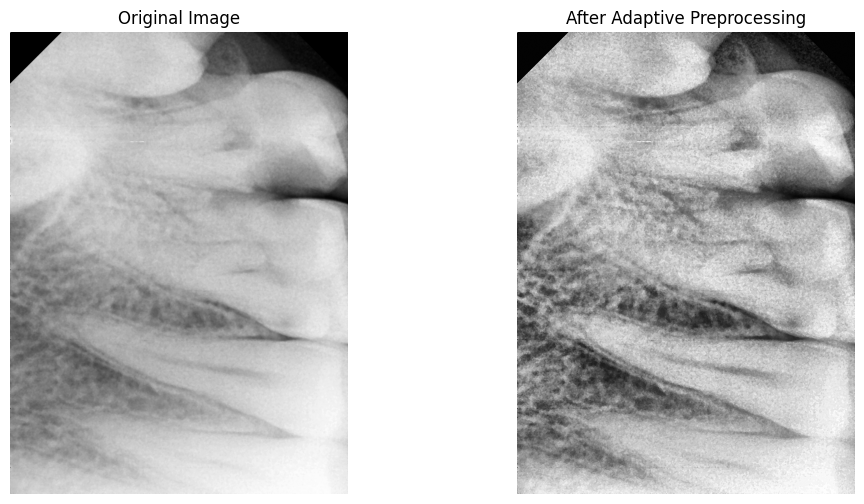

In [41]:
import cv2
import matplotlib.pyplot as plt

# Assuming 'img' is your input image (grayscale or single channel)

# Example: load your image (replace with your image loading code)
# img = cv2.imread('your_image.png', cv2.IMREAD_GRAYSCALE)

# Suppose you have the metrics for this image, e.g.
contrast_std = metrics['contrast_std']
sharpness_laplacian = metrics['sharpness_laplacian']
noise_estimate = metrics['noise_estimate']
   

# Apply adaptive preprocessing
processed_img = adaptive_preprocessing(img, metrics)

# Show before and after images side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("After Adaptive Preprocessing")
plt.imshow(processed_img, cmap='gray')
plt.axis('off')

plt.show()


calculate and log the metrics

In [40]:
metrics = compute_image_metrics(img, filename=os.path.basename(file_path), operation="original")  # Get metrics
adapted_img = adaptive_preprocessing(img, metrics)
compute_image_metrics(adapted_img, filename=os.path.basename(file_path), operation="NoiseCapped_NLMeans_Denoising_adaptive_preprocessing")  # Log result



⚠️ Skipped duplicate entry for IS20250218_193621_8940_10081171.dcm (original)
0.2506662075194083
⚠️ Skipped duplicate entry for IS20250218_193621_8940_10081171.dcm (NoiseCapped_NLMeans_Denoising_adaptive_preprocessing)


{'filename': 'IS20250218_193621_8940_10081171.dcm',
 'preprocessing_operation': 'NoiseCapped_NLMeans_Denoising_adaptive_preprocessing',
 'brightness': 163.92333447488585,
 'contrast_std': 54.44151170382922,
 'michelson_contrast': 0.9999999607843153,
 'rms_contrast': 54.44151170382922,
 'sharpness_laplacian': 1020.3566725908531,
 'sharpness_tenengrad': 55.424620760774914,
 'noise_estimate': 0.0}

To save the image

In [170]:
save_preprocessed_image(adapted_img, file_path, suffix="Noise_capped_adaptive")

🖼️ Saved preprocessed image to preprocessed_images\IS20250218_193621_8940_10081171_Noise_capped_adaptive.png


'preprocessed_images\\IS20250218_193621_8940_10081171_Noise_capped_adaptive.png'

## Logic and Heuristics

### Contrast adjustment : Metric Used:- contrast_std

Low standard deviation of contrast indicates a "flat" image lacking tonal separation. Enhancing contrast can improve detail visibility, especially in medical imaging.

Heuristic thresholds:

> < 40: Image is poorly contrasted → use strong CLAHE (clipLimit=3.0).

> 40–60: Image has moderate contrast → use mild CLAHE (clipLimit=2.0).

> greater than 60: Already good contrast → use minimal enhancement (clipLimit=1.0) or skip.


database info :
> Min contrast_std: ~30 ,Mean: ~48, Max: ~83

Hence, <40 marks low contrast images.

### Sharpening : Metric Used:- sharpness_laplacian
Low sharpness suggests blur. Sharpening recovers edge details.


Heuristic thresholds:

> < 150: Very soft image → apply strong unsharp masking (amount = 1.5).

> 150–250: Moderately sharp image → apply moderate sharpening (amount = 1.0).

>  greater than 250: Already sharp → apply light sharpening (amount = 0.5).

Dataset info:
> Mean sharpness: ~183, Min: ~83, Max: ~374

Values under 150 clearly mark less detailed images, hence stronger sharpening is justified.

### Denoising - Metric used:- noise_estimate

Noise can obscure fine details and mislead diagnosis, especially in radiographs.

Heuristic thresholds:

> 0.02: High noise (capped outlier or true) → apply strong denoising (e.g., Non-Local Means).

> ≤ 0.02: Negligible noise → skip denoising to preserve texture and edges.


Dataset info:
> Mean noise: ~0.019 ,Median: 0.0 ,Max: 0.25 (strong outlier)

Only 1 out of 13 samples is above mean, indicating noise is usually near-zero. Hence:

A cap at 0.02 is used to suppress outlier influence.

Avoid over-denoising clean images.

## drawbacks

all the thresholds are hardcoded based on our 13 samples - generalisation problem

outlier Sensitivity - heavily influence decision unless uncapped - manual capping is just a work 

No Interdependancy between Metrics - each enhancements step is decided independantly

No Feedback - re-evaluation - 
Problem: Some adjustments may: Over-sharpen already detailed images, Over-enhance noise, Flatten intensity ranges

just one noise metric used - compute multiple noise metrics

computational cost - fastNlMeansDenoising is computationally expensive - 

### a rule-based system or even ML models that consider joint metric values to decide the preprocessing sequence and strength.

## Machine Learning / Deep Learning Approach - A proof of concept

Limitaions :- 13 images only

Need to augument the data 

Denoising Autoencoder - Learn to remove noise by training a model on pairs of clean and artificially degraded images.

Load and Rename Columns

In [61]:
import pandas as pd

df_metrics = pd.read_csv("NEW_image_quality_metrics.csv")  # Replace with your actual filename


In [62]:
df_metrics = df_metrics.rename(columns={
    'Brightness': 'brightness',
    'Contrast_STD': 'contrast',
    'Sharpness_Laplacian': 'sharpness',
    'Noise_STD_Wavelet': 'noise'
})


Label Quality categories

In [63]:
def label_image_quality(row):
    print(row[['contrast', 'sharpness', 'noise']])
    if row['contrast'] < 35:
        return 'low_contrast'
    elif row['sharpness'] < 120:
        return 'blurry'
    elif row['noise'] > 3.7:
        return 'noisy'
    else:
        return 'good'


In [64]:
# Add this new column to the dataframe
# df_metrics['quality_class'] = df_metrics.apply(label_image_quality, axis=1)
df_metrics['quality_class'] = df_metrics.apply(label_image_quality, axis=1)


contrast     49.159847
sharpness     82.74192
noise         2.711381
Name: 0, dtype: object
contrast       76.73254
sharpness    116.697883
noise          3.541837
Name: 1, dtype: object
contrast      72.30087
sharpness    101.51438
noise         3.228921
Name: 2, dtype: object
contrast      83.57152
sharpness    89.436735
noise         3.174528
Name: 3, dtype: object
contrast     50.173656
sharpness    175.69812
noise         4.061996
Name: 4, dtype: object
contrast      34.42806
sharpness    236.92314
noise         4.813602
Name: 5, dtype: object
contrast      43.952415
sharpness    373.517167
noise          6.409094
Name: 6, dtype: object
contrast      37.453518
sharpness    213.334695
noise          3.420899
Name: 7, dtype: object
contrast      31.058662
sharpness    114.363029
noise          2.727344
Name: 8, dtype: object
contrast      42.477985
sharpness    190.674339
noise          3.338426
Name: 9, dtype: object
contrast       35.30894
sharpness    181.193633
noise           3

In [66]:
print(df_metrics.columns)
# df_metrics.head(5)

Index(['Filename', 'brightness', 'contrast', 'Michelson_Contrast', 'sharpness',
       'Sharpness_Tenengrad', 'Noise_STD_CenterPatch', 'noise',
       'Noise_STD_Estimated', 'quality_class'],
      dtype='object')


In [68]:
print(y.value_counts())


quality_class
good            5
blurry          4
noisy           3
low_contrast    3
Name: count, dtype: int64


In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Features for training
features = ['brightness', 'contrast', 'sharpness', 'noise']
X = df_metrics[features]
y = df_metrics['quality_class']

# Split dataset (80% train, 20% test), stratify to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Initialize and train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

      blurry       0.50      1.00      0.67         1
        good       1.00      0.50      0.67         2
low_contrast       0.50      1.00      0.67         1
       noisy       0.00      0.00      0.00         1

    accuracy                           0.60         5
   macro avg       0.50      0.62      0.50         5
weighted avg       0.60      0.60      0.53         5

Confusion Matrix:
 [[1 0 0 0]
 [0 1 1 0]
 [0 0 1 0]
 [1 0 0 0]]


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

cross-validation instead of a single split

In [83]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\skl

              precision    recall  f1-score   support

      blurry       1.00      1.00      1.00         1
        good       0.50      1.00      0.67         1
       noisy       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

      blurry       1.00      1.00      1.00         1
        good       0.50      1.00      0.67         1
       noisy       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3

              precision    recall  f1-score   support

      blurry       1.00      1.00      1.00         1
        good       1.00      1.00      1.00         1
low_contrast       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

              precision    recall  f1-score   support

      blurry       1.00      1.00      1.00         1
        good       1.00      1.00      1.00         1
low_contrast       1.00      1.00      1.00         1

    accuracy        

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Augumentation

In [84]:
import pandas as pd
import numpy as np

# Your original dataframe
df = df_metrics.copy()  # assuming df_metrics is your original dataframe

# Number of augmented samples you want
desired_total = 100
current_count = len(df)
samples_to_generate = desired_total - current_count

# Columns to augment (numeric features only)
features = ['brightness', 'contrast', 'sharpness', 'noise']

# Small noise scale (adjust as needed)
noise_scale = 0.05  # 5% noise relative to the feature values

# Create augmented samples by jittering existing rows
augmented_rows = []
for _ in range(samples_to_generate):
    # Randomly pick a row from original data
    base_row = df.sample(n=1).iloc[0]
    
    # Create new row with noise added to numeric features
    new_row = base_row.copy()
    for feat in features:
        noise = np.random.normal(loc=0, scale=noise_scale * base_row[feat])
        new_row[feat] = max(new_row[feat] + noise, 0)  # ensure no negative values if not allowed
    
    augmented_rows.append(new_row)

# Convert augmented rows list to DataFrame
df_augmented = pd.DataFrame(augmented_rows)

# Combine original + augmented
df_combined = pd.concat([df, df_augmented], ignore_index=True)

# Optional: Reset index
df_combined.reset_index(drop=True, inplace=True)

# Save to CSV
df_combined.to_csv("augmented_metrics.csv", index=False)

print(f"Original samples: {current_count}")
print(f"Augmented samples added: {samples_to_generate}")
print(f"Total samples saved: {len(df_combined)}")


Original samples: 15
Augmented samples added: 85
Total samples saved: 100


ML wit augumented data

In [85]:
import pandas as pd

# Load augmented CSV
df_aug = pd.read_csv("augmented_metrics.csv")

# Check data
print(df_aug.head())
print(df_aug['quality_class'].value_counts())


                              Filename  brightness   contrast  \
0  IS20250115_171841_9465_61003253.dcm   174.68030  49.159847   
1  IS20250115_190348_9148_86297118.dcm   130.84195  76.732540   
2  IS20250115_191316_7227_10120577.dcm   127.77650  72.300870   
3  IS20250116_180218_7445_56958340.dcm   116.35364  83.571520   
4  IS20250218_193552_3393_78829426.dcm   175.43419  50.173656   

   Michelson_Contrast   sharpness  Sharpness_Tenengrad  Noise_STD_CenterPatch  \
0                 1.0   82.741920            17.859888              26.233790   
1                 1.0  116.697883            29.187775              53.585150   
2                 1.0  101.514380            26.014968              74.081040   
3                 1.0   89.436735            26.594470              86.071960   
4                 1.0  175.698120            30.250547              33.575405   

      noise  Noise_STD_Estimated quality_class  
0  2.711381             0.250666        blurry  
1  3.541837             

to clean this up

In [86]:
df_aug = df_aug.dropna()


In [87]:
# Replace whitespace-only strings with NaN
df_aug.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

# Drop rows with any newly introduced NaN (from empty strings)
df_aug = df_aug.dropna()


In [88]:
df_aug.reset_index(drop=True, inplace=True)


In [89]:
print(df_aug.info())        # Check if nulls are gone
print(df_aug.head())        # Preview cleaned data
print(df_aug['quality_class'].value_counts())  # Class distribution


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Filename               96 non-null     object 
 1   brightness             96 non-null     float64
 2   contrast               96 non-null     float64
 3   Michelson_Contrast     96 non-null     float64
 4   sharpness              96 non-null     float64
 5   Sharpness_Tenengrad    96 non-null     float64
 6   Noise_STD_CenterPatch  96 non-null     float64
 7   noise                  96 non-null     float64
 8   Noise_STD_Estimated    96 non-null     float64
 9   quality_class          96 non-null     object 
dtypes: float64(8), object(2)
memory usage: 7.6+ KB
None
                              Filename  brightness   contrast  \
0  IS20250115_171841_9465_61003253.dcm   174.68030  49.159847   
1  IS20250115_190348_9148_86297118.dcm   130.84195  76.732540   
2  IS20250115_191316_

In [90]:
def clean_dataframe(df):
    df = df.dropna()
    df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
    df = df.dropna()
    df.reset_index(drop=True, inplace=True)
    return df

df_aug = clean_dataframe(df_aug)


Prepare features and labels

In [91]:
features = ['brightness', 'contrast', 'sharpness', 'noise']  # update if more metrics exist
X = df_aug[features]
y = df_aug['quality_class']


Encode target labels

In [92]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encodes strings to integers


In [93]:
le.classes_

array(['blurry', 'good', 'low_contrast', 'noisy'], dtype=object)

Split into training and testing

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


Model Traineing and Eval

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

      blurry       0.80      0.80      0.80         5
        good       1.00      1.00      1.00         5
low_contrast       1.00      1.00      1.00         5
       noisy       0.80      0.80      0.80         5

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20

Confusion Matrix:
 [[4 0 0 1]
 [0 5 0 0]
 [0 0 5 0]
 [1 0 0 4]]


In [120]:
import joblib

# Save trained model and label encoder
joblib.dump(clf, 'rf_quality_classifier.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

Feature importance plot

C:\Users\Admin\AppData\Local\Temp\ipykernel_31056\3550990159.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')


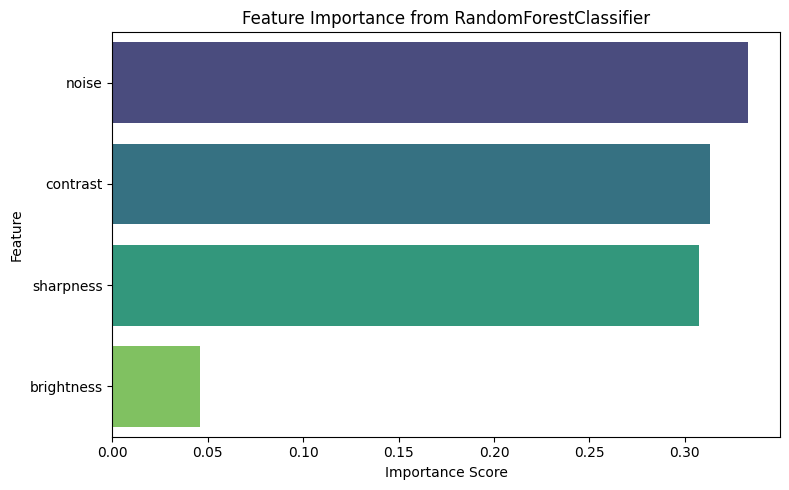

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
importances = clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier plotting
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from RandomForestClassifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Decesion tree plot 

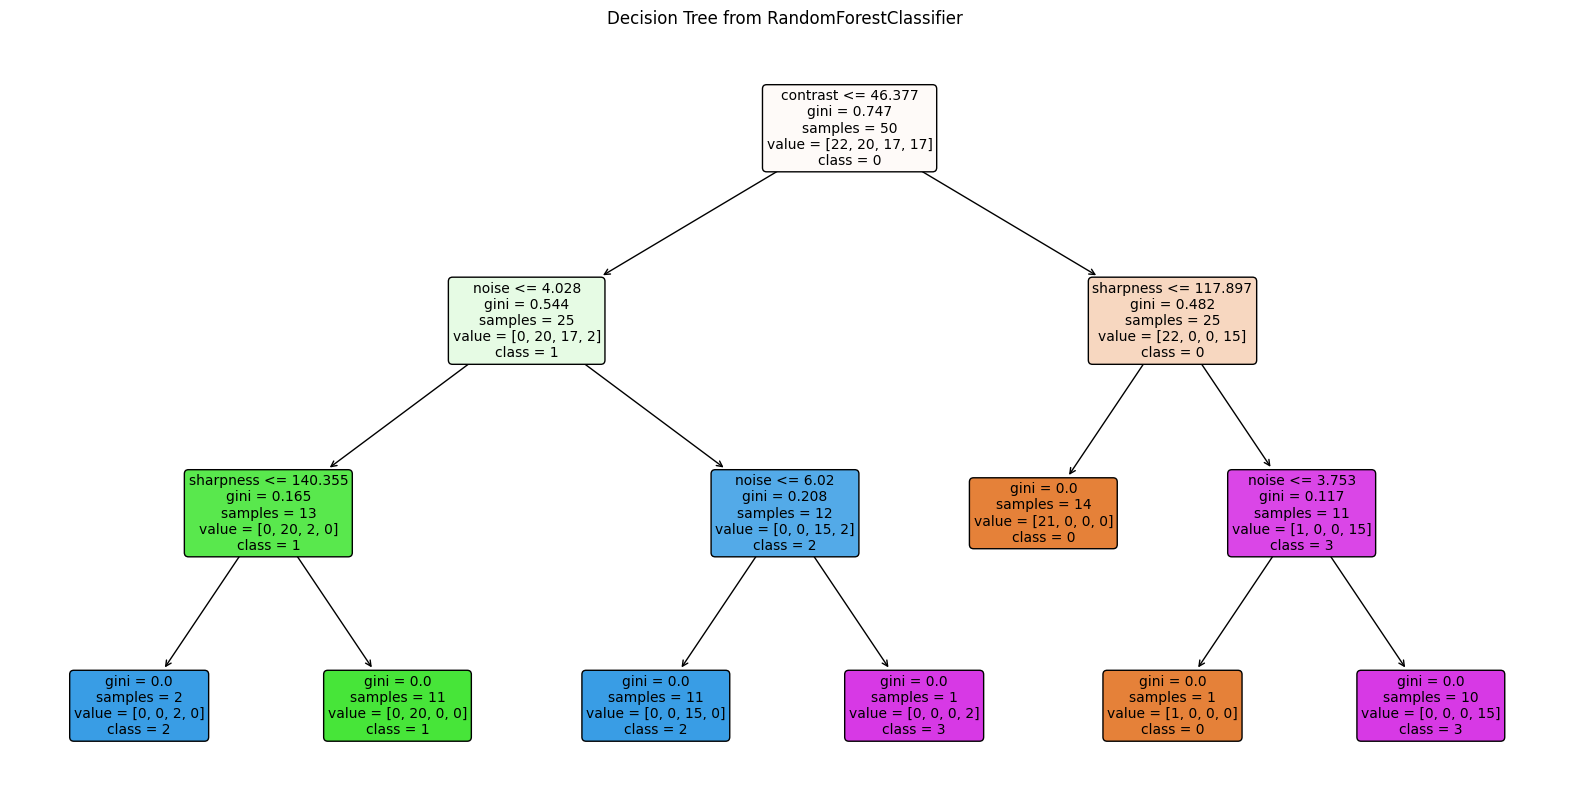

In [98]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Convert class names to string if they are integers
class_names_str = [str(cls) for cls in clf.classes_]

plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    feature_names=X_train.columns,
    class_names=class_names_str,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree from RandomForestClassifier")
plt.show()

Saving the tree plot 

In [99]:
import os
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Ensure 'plots' folder exists
os.makedirs("plots", exist_ok=True)

# Convert class names to string if needed
class_names_str = [str(cls) for cls in clf.classes_]

# Plot and save the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    feature_names=X_train.columns,
    class_names=class_names_str,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree from RandomForestClassifier")

# Save the figure
plt.savefig("plots/decision_tree.png", bbox_inches="tight")
plt.close()  # Close the plot to free memory


## Why Use ML for Adaptive Preprocessing?

ML-based adaptive preprocessing:

Learns from data: It uses prior labeled examples (e.g., blurry, noisy, good, low contrast) to guide enhancement strategies.

Generalizes: Works across modalities (CT, MRI, etc.) and varying acquisition quality.

Optimizes preprocessing per image, instead of using a one-size-fits-all approach.

Helps downstream tasks (e.g., segmentation, detection) by improving task-relevant image quality.

## When Should You Use ML for Adaptive Preprocessing?


Use ML when:

Image quality is highly variable (e.g., real-world scans, multi-center datasets).

Quality affects downstream ML model performance (e.g., cancer detection).

You want to automatically enhance large-scale datasets without manual tuning.

You have:

A labeled quality dataset (like you created).

A classifier to detect quality class.

A set of enhancement strategies tailored per class.

## What Do You Need for ML-based Adaptive Preprocessing?

✅ Labeled Quality Dataset	Images tagged as good, blurry, noisy, etc.

✅ Quality Classifier Model	e.g., Random Forest, CNN to detect image class.

✅ Enhancement Strategies	One per class — e.g., sharpen blurry, denoise noisy, etc.

🔁 Adaptive Pipeline	Pipeline that applies enhancement based on predicted class.

## what i built here

this is a  Quality classsifier that classifies into 4 classes - blurry , good , noisy , low_contrast

This is step 1 of Adaptive preprocessing - after we predict the quality class --> appy class specific enahncements

blurry --> apply sharpening

Noisy --> Apply denoising

low_contrast  --> apply contrast enhancement 

good  --> no processing 


In [100]:
df.to_csv("augmented_quality_dataset.csv", index=False)


# Adaptive Enhancement Pipeline

load csv

In [105]:
import pandas as pd

df_dataset_aug = pd.read_csv("augmented_quality_dataset.csv")
df_dataset_aug.head()


Filename  brightness   contrast  \
0  IS20250115_171841_9465_61003253.dcm   174.68030  49.159847   
1  IS20250115_190348_9148_86297118.dcm   130.84195  76.732540   
2  IS20250115_191316_7227_10120577.dcm   127.77650  72.300870   
3  IS20250116_180218_7445_56958340.dcm   116.35364  83.571520   
4  IS20250218_193552_3393_78829426.dcm   175.43419  50.173656   

   Michelson_Contrast   sharpness  Sharpness_Tenengrad  Noise_STD_CenterPatch  \
0                 1.0   82.741920            17.859888              26.233790   
1                 1.0  116.697883            29.187775              53.585150   
2                 1.0  101.514380            26.014968              74.081040   
3                 1.0   89.436735            26.594470              86.071960   
4                 1.0  175.698120            30.250547              33.575405   

      noise  Noise_STD_Estimated quality_class  
0  2.711381             0.250666        blurry  
1  3.541837             0.000000        blurry  
2  3.228921             0.000000        blurry  
3  3.174528             0.000000        blurry  
4  4.061996             0.000000         noisy

Define Enhancement Functions by Quality Class

In [106]:
import cv2
import numpy as np
from skimage import exposure

def enhance_blurry(img):
    # Apply sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def enhance_noisy(img):
    # Apply median filtering
    return cv2.medianBlur(img, 3)

def enhance_low_contrast(img):
    # Apply histogram equalization
    if len(img.shape) == 3 and img.shape[2] == 3:
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    else:
        return cv2.equalizeHist(img)

def enhance_good(img):
    # No enhancement
    return img


In [107]:
import os

image_folder = "Images_Data_science_intern"
image_files = sorted(os.listdir(image_folder))  # sort to align with CSV order if matching

# Add full paths as a new column
df_dataset_aug['image_path'] = [os.path.join(image_folder, f) for f in image_files]


In [112]:
print(df_dataset_aug.columns.tolist())


['Filename', 'brightness', 'contrast', 'Michelson_Contrast', 'sharpness', 'Sharpness_Tenengrad', 'Noise_STD_CenterPatch', 'noise', 'Noise_STD_Estimated', 'quality_class', 'image_path', 'enhanced_path']


Apply Adaptive Enhancement

In [110]:

from tqdm import tqdm
import os

output_dir = "adaptive_enhanced_images"
os.makedirs(output_dir, exist_ok=True)

def enhance_image_row(row):
    path = row['image_path']
    label = row['quality_class']
    img = cv2.imread(path)

    if img is None:
        return None

    if label == 'blurry':
        enhanced = enhance_blurry(img)
    elif label == 'noisy':
        enhanced = enhance_noisy(img)
    elif label == 'low_contrast':
        enhanced = enhance_low_contrast(img)
    else:
        enhanced = enhance_good(img)

    out_path = os.path.join(output_dir, os.path.basename(path))
    cv2.imwrite(out_path, enhanced)
    return out_path

df_dataset_aug['enhanced_path'] = df_dataset_aug.apply(enhance_image_row, axis=1)
df_dataset_aug.dropna(subset=['enhanced_path'], inplace=True)



Evaluate Quality Improvements

In [114]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def compute_metrics(row):
    original = cv2.imread(row['image_path'])
    enhanced = cv2.imread(row['enhanced_path'])

    if original is None or enhanced is None:
        return pd.Series([None, None])

    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

    psnr_val = psnr(original_gray, enhanced_gray)
    ssim_val = ssim(original_gray, enhanced_gray)

    return pd.Series([psnr_val, ssim_val])

df_dataset_aug[['psnr', 'ssim']] = df_dataset_aug.apply(compute_metrics, axis=1)


Visualize or Save the Results

In [118]:
print(df_dataset_aug[['quality_class', 'psnr', 'ssim']].groupby('quality_class').mean())
df_dataset_aug.to_csv("evaluation_results.csv", index=False)


                    psnr      ssim
quality_class                     
noisy          38.755285  0.962881


In [119]:
df_dataset_aug.to_csv('output_metrics.csv', index=True)  # index=True if you want to keep the index (like quality_class)


# Evalution and Comparision

PSNR: Measures signal fidelity; higher values mean less distortion.

SSIM: Assesses structural similarity; closer to 1 indicates better quality.

Brightness: Evaluates overall image illumination.

Contrast (STD & Michelson): Reflects feature visibility and intensity range.

Sharpness (Laplacian, Tenengrad): Indicates edge clarity and detail preservation.

Noise (Wavelet, Flat Region STD): Measures graininess and unwanted variations.

Edge Count (Canny): Assesses clarity of anatomical structures.



Original Images: Often lack contrast, sharpness, or contain noise.

Static Enhancement: Applies fixed filters; moderate quality improvement.

Heuristic Adaptive: Uses rules to target specific flaws; better than static.

ML-Based Adaptive: Learns quality patterns; yields the most balanced results.

Advantages: Tailored enhancement, better clarity, data-driven improvements.

Limitations: Depends on model accuracy, lacks ground truth, higher compute cost.

